## EY Data Challenge - Landsat Land Surface Temperature

This sample notebook can be used to create a Landsat Land Surface Temperature (LST) product. The notebook creates a cloud-filtered median mosaic for any time period and location and then creates the LST product. A median mosaic reflects the "median" value of pixels for all spectral bands in the time series. When scenes within a time series contain clouds, the use of a median calculation can statistically remove clouds from the final median mosaic product, assuming there are plenty of clear pixels within the time series. The baseline data is [Landsat Collection-2 Level-2](https://www.usgs.gov/landsat-missions/landsat-collection-2) data from the MS Planetary Computer catalog.

In [2]:
# %pip install numpy xarray rioxarray rasterio
# %pip install matplotlib
# %pip install stackstac pystac_client planetary_computer odc
%pip install osmnx

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Import common GIS tools
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray as rio
import rasterio
from matplotlib.cm import jet,RdYlGn

# Import Planetary Computer tools
import stackstac
import pystac_client
import planetary_computer 
from odc.stac import stac_load

### Discover and load the data for analysis

First, we define our area of interest using latitude and longitude coordinates. 

In [4]:
# Define the bounding box for the entire data region using (Latitude, Longitude)
# This is the region of New York City that contains our temperature dataset
lower_left = (40.75, -74.01)
upper_right = (40.88, -73.86)

In [5]:
# Calculate the bounds for doing an archive data search
# bounds = (min_lon, min_lat, max_lon, max_lat)
bounds = (lower_left[1], lower_left[0], upper_right[1], upper_right[0])

In [6]:
# Define the time window
# We will use a period of 3 months to search for data
time_window = "2021-06-01/2021-09-01"

Using the `pystac_client` we can search the Planetary Computer's STAC endpoint for items matching our query parameters. The query searches for "low cloud" scenes with overall cloud cover <20%. We will also limit our search to Landsat-8 to avoid the Landsat-7 scan line corrector failure. The result is the number of scenes matching our search criteria that touch our area of interest. Some of these may be partial scenes or contain clouds.

In [7]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = stac.search(
    bbox=bounds, 
    datetime=time_window,
    collections=["landsat-c2-l2"],
    query={"eo:cloud_cover": {"lt": 50},"platform": {"in": ["landsat-8"]}},
)

In [8]:
items = list(search.get_items())
print('This is the number of scenes that touch our region:',len(items))

This is the number of scenes that touch our region: 8


Next, we'll load the data into an [xarray](https://xarray.pydata.org/en/stable/) DataArray using [stackstac](https://stackstac.readthedocs.io/). We will only keep the commonly used spectral bands (Red, Green, Blue, NIR, Surface Temperature). There are also several other <b>important settings for the data</b>: We have changed the projection to epsg=4326 which is standard latitude-longitude in degrees. We have specified the spatial resolution of each pixel to be 30-meters. 

In [9]:
signed_items = [planetary_computer.sign(item).to_dict() for item in items]

In [10]:
# Define the pixel resolution for the final product
# Define the scale according to our selected crs, so we will use degrees
resolution = 30  # meters per pixel 
scale = resolution / 111320.0 # degrees per pixel for crs=4326 

### Landsat Band Summary 
The following list of bands will be loaded by the Open Data Cube (ODC) stac command:<br>
We will use two load commands to separate the RGB data from the Surface Temperature data.<br><br>
Band 2 = blue = 30m<br>
Band 3 = green = 30m<br>
Band 4 = red = 30m<br>
Band 5 = nir08 (near infrared) = 30m<br>
Band 11 = Surface Temperature = lwir11 = 100m

In [11]:
data1 = stac_load(
    items,
    bands=["red", "green", "blue", "nir08", "swir16"],
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=planetary_computer.sign,
    bbox=bounds
)

In [12]:
data2 = stac_load(
    items,
    bands=["lwir11"],
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=planetary_computer.sign,
    bbox=bounds
)

Since the data matching our query isn't too large we can persist it in distributed memory. Once in memory, subsequent operations will be much faster.

In [ ]:
# View the dimensions of our XARRAY and the loaded variables
# This insures we have the right coordinates and spectral bands in our xarray
# display(data1)
# display(data2)

In [14]:
# Persist the data in memory for faster operations
data1 = data1.persist()
data2 = data2.persist()

### Scaling Datasets
Landsat Collection-2 Level-2 products require scaling before creating valid output products. <br>
Scale factors for the RGB and NIR bands differ from scale factors for the Surface Temperature band.<br>

In [15]:
# Scale Factors for the RGB and NIR bands 
scale1 = 0.0000275 
offset1 = -0.2 
data1 = data1.astype(float) * scale1 + offset1

In [16]:
# Scale Factors for the Surface Temperature band
scale2 = 0.00341802 
offset2 = 149.0 
kelvin_celsius = 273.15 # convert from Kelvin to Celsius
data2 = data2.astype(float) * scale2 + offset2 - kelvin_celsius

### View RGB (real color) images from the time series
You will notice that some of the scenes have clouds and some of the scenes have missing data due to scene boundary issues. Since Landsat is a descending orbit path across the equator, the time of acquisition for the scenes below is about 11:30am local time (note the time on the image is UTC time). Also, these images are merely for quick review and are not scaled correctly to reflect the proper Lat-Lon ratios. 

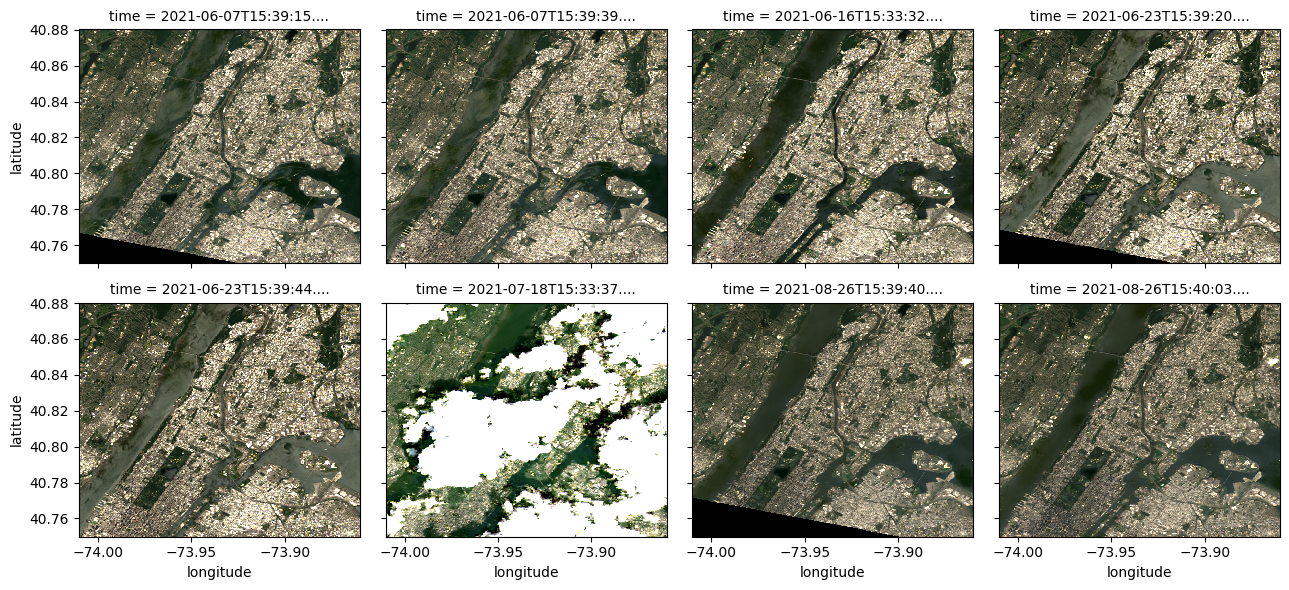

In [17]:
plot_data = data1[["red","green","blue"]].to_array()
plot_data.plot.imshow(col='time', col_wrap=4, robust=True, vmin=0, vmax=0.25)
plt.show()

### Output Products

We will pick the best the best scene (no clouds, no missing data) to build our output products. This will not require any median filtering calculations as we will just pick one date from the time series. Finally, the numbering for these scenes starts at ZERO and goes from the top-left across the rows to reach the total number of scenes in the data array shown above. 

In [36]:
# Pick one of the scenes above (numbering starts with 0)
scene = 2

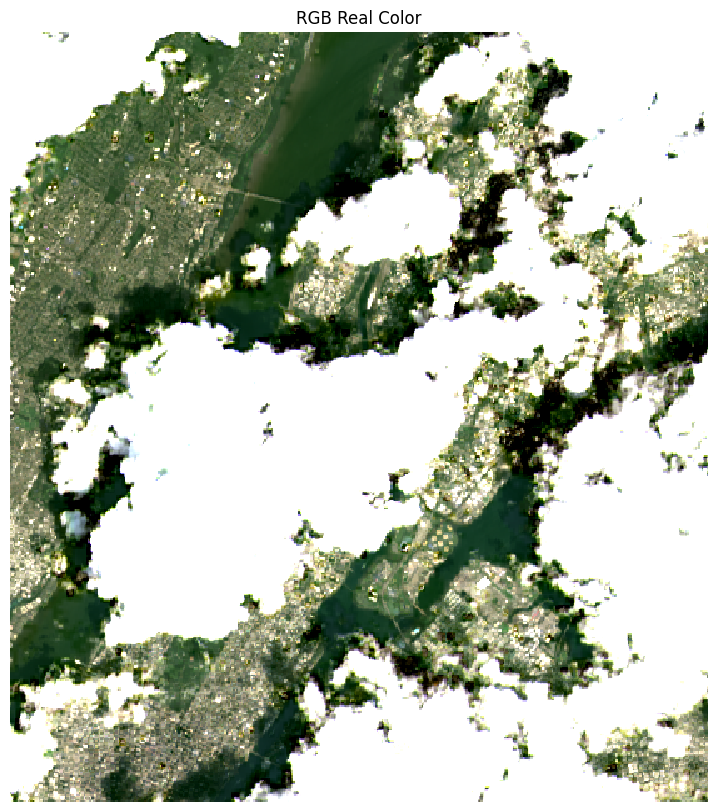

In [37]:
# Plot an RGB Real Color Image for a single date
fig, ax = plt.subplots(figsize=(9,10))
data1.isel(time=scene)[["red", "green", "blue"]].to_array().plot.imshow(robust=True, ax=ax, vmin=0.0, vmax=0.25)
ax.set_title("RGB Real Color")
ax.axis('off')
plt.show()

The <b>Normalized Difference Vegetation Index (NDVI)</b> is used to measure the "greenness" of vegetation and has a range of 0.0 to 1.0. Low values (0.0 to 0.25) reflect a lack of vegetation (bare soil, urban, water), middle values (0.25 to 0.6) reflect grasslands or croplands in their growing state, and high values (0.6 to 1.0) reflect dense vegetation such as trees or croplands at their peak vegetation state. Such information can be relevant to modeling urban heating as the proximity to vegetation or "green space" can mitigate urban heating. The equation uses two spectral bands where: <b>NDVI = (NIR-Red) / (NIR+Red).

In [52]:
# Calculate NDVI for the median mosaic
ndvi_data = (data1.isel(time=scene).nir08-data1.isel(time=scene).red)/(data1.isel(time=scene).nir08+data1.isel(time=scene).red)
ndvi_data

AttributeError: 'NoneType' object has no attribute 'render'

<xarray.DataArray (latitude: 484, longitude: 558)> Size: 2MB
dask.array<truediv, shape=(484, 558), dtype=float64, chunksize=(484, 558), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 4kB 40.88 40.88 40.88 ... 40.75 40.75 40.75
  * longitude    (longitude) float64 4kB -74.01 -74.01 -74.01 ... -73.86 -73.86
    spatial_ref  int32 4B 4326
    time         datetime64[ns] 8B 2021-07-18T15:33:37.770322

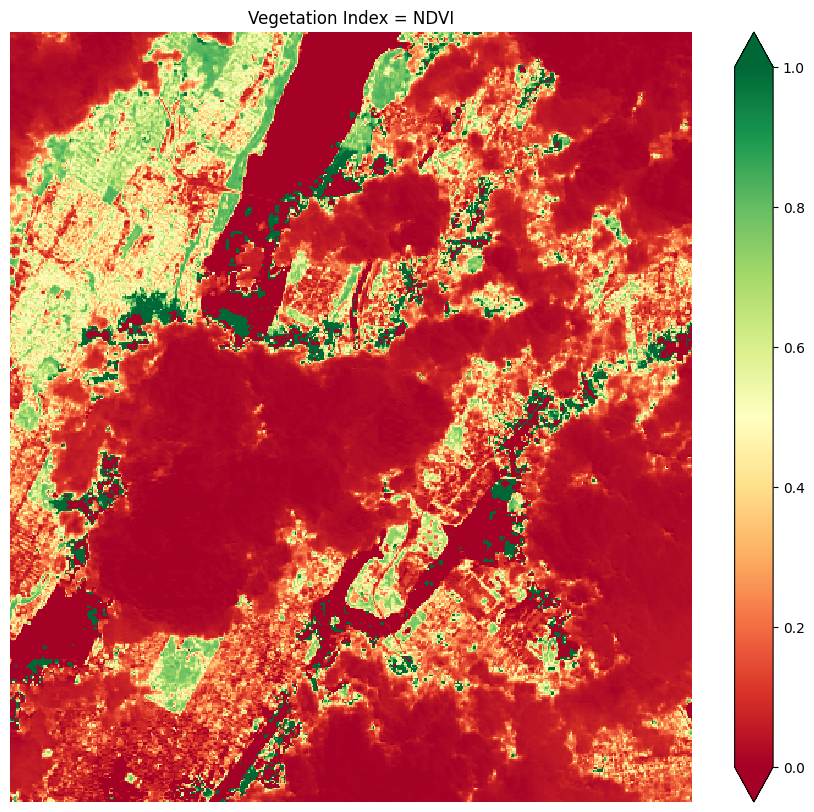

In [39]:
fig, ax = plt.subplots(figsize=(11,10))
ndvi_data.plot.imshow(vmin=0.0, vmax=1.0, cmap="RdYlGn")
plt.title("Vegetation Index = NDVI")
plt.axis('off')
plt.show()

### NDBI

In [ ]:
ndbi_data = (data1.isel(time=scene).swir16-data1.isel(time=scene).nir08)/(data1.isel(time=scene).swir16+data1.isel(time=scene).nir08)

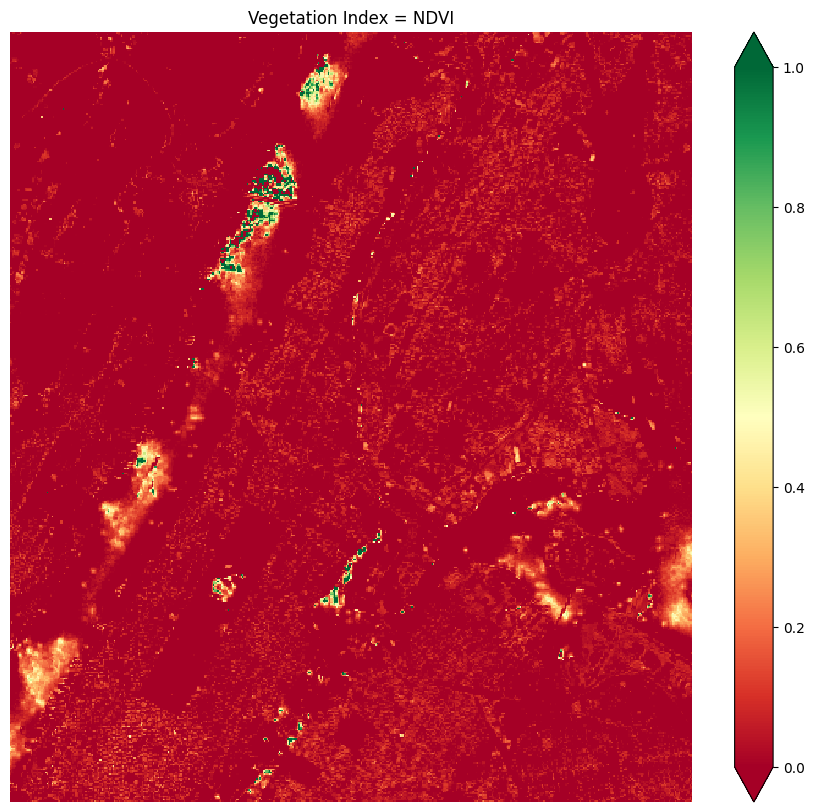

In [33]:
fig, ax = plt.subplots(figsize=(11,10))
ndbi_data.plot.imshow(vmin=0.0, vmax=1.0, cmap="RdYlGn")
plt.title("Vegetation Index = NDVI")
plt.axis('off')
plt.show()

### Landsat Surface Temperature

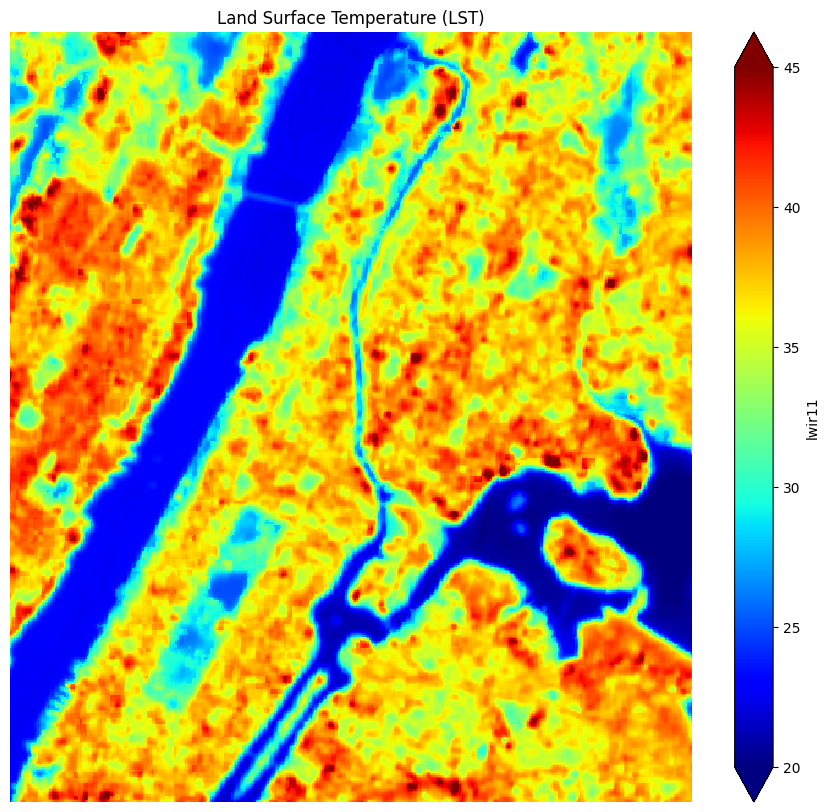

In [22]:
fig, ax = plt.subplots(figsize=(11,10))
data2.isel(time=scene).lwir11.plot.imshow(vmin=20.0, vmax=45.0, cmap="jet")
plt.title("Land Surface Temperature (LST)")
plt.axis('off')
plt.show()

### Save the output data in a GeoTIFF file

In [23]:
# Only select one of the time slices to output
data3 = data2.isel(time=scene)

In [24]:
filename = "Landsat_LST.tiff"

In [25]:
# Calculate the dimensions of the file
height = data3.dims["latitude"]
width = data3.dims["longitude"]

In [ ]:
# Define the Coordinate Reference System (CRS) to be common Lat-Lon coordinates
# Define the tranformation using our bounding box so the Lat-Lon information is written to the GeoTIFF
gt = rasterio.transform.from_bounds(lower_left[1],lower_left[0],upper_right[1],upper_right[0],width,height)
data3.rio.write_crs("epsg:4326", inplace=True)
data3.rio.write_transform(transform=gt, inplace=True)

In [27]:
# Create the GeoTIFF output file using the defined parameters 
with rasterio.open(filename,'w',driver='GTiff',width=width,height=height,
                   crs='epsg:4326',transform=gt,count=1,compress='lzw',dtype='float64') as dst:
    dst.write(data3.lwir11,1)
    dst.close()

In [28]:
# Show the new saved output file
!ls *.tiff

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [45]:
file_path = "Landsat_LST.tiff"

In [46]:
with rasterio.open(fp=file_path) as dst:
    print(dst.meta)

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 558, 'height': 484, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(0.00026881720430108546, 0.0, -74.01,
       0.0, -0.0002685950413223193, 40.88)}


In [51]:
# with rasterio.open(file_path) as dst:
#     lst = dst.read(1)
#     print(lst)

[[38.04530306 37.28992064 36.77721764 ... 38.51698982 38.44179338
  38.09657336]
 [37.66248482 36.43199762 35.93638472 ... 38.47255556 38.30165456
  37.80945968]
 [37.33777292 36.2576786  35.86802432 ... 38.53407992 38.2743104
  37.79920562]
 ...
 [23.7989957  24.78338546 28.635494   ... 37.3856252  37.39587926
  37.58387036]
 [24.021167   25.17303974 28.98755006 ... 37.5565262  37.39587926
  37.62830462]
 [24.22966622 27.14523728 28.74487064 ... 38.07264722 37.58387036
  37.7786975 ]]
